In [1]:
!nvidia-smi

Fri Jul  7 10:29:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install torchvision==0.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.


In [3]:
! pip install craft_text_detector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [4]:
from google.colab import drive
drive.mount('/content/drive')

! unzip -q '/content/drive/MyDrive/hateful_memes.zip' -d '/content/data'

Mounted at /content/drive


In [5]:
import os
import cv2
import math
import shutil
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    empty_cuda_cache
)

warnings.filterwarnings('ignore')

In [6]:
def inpaint_text(img_path,craft_net=None, refine_net=None):
    # read image
    output_dir = '/content/data/hateful_memes/cleaned_img/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    img_name = os.path.basename(img_path)
    img_save_path = os.path.join(output_dir, img_name)

    if os.path.exists(img_save_path):
        return None

    image = read_image(img_path)

    # perform prediction
    prediction_result = get_prediction(
        image=image,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.7,
        link_threshold=0.4,
        low_text=0.4,
        cuda=True,
        long_size=1280
    )

    prediction_boxes = prediction_result["boxes"]
    mask = np.zeros(image.shape[:2], dtype="uint8")

    for i in range(len(prediction_boxes)):
        box = prediction_boxes[i]
        x0, y0 = box[0]
        x1, y1 = box[1] 
        x2, y2 = box[2]
        x3, y3 = box[3] 
        x_mid0 = int((x1 + x2)/2)
        y_mid0 = int((y1 + y2)/2)
        x_mid1 = int((x0 + x3)/2)
        y_mid1 = int((y0 + y3)/2)

        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255,    
        thickness)
        img = cv2.inpaint(image, mask, 4,cv2.INPAINT_TELEA)

    cv2.imwrite(img_save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [7]:
# Remove text from images and save them to a new directory
data_dir = "/content/data/hateful_memes/img/"

# load models
refine_net = load_refinenet_model(cuda=True)
craft_net = load_craftnet_model(cuda=True)

for img_path in tqdm(os.listdir(data_dir)):
    inpaint_text(os.path.join(data_dir, img_path), craft_net, refine_net)

Craft text refiner weight will be downloaded to /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth


Downloading...
From: https://drive.google.com/uc?id=1xcE9qpJXp4ofINwXWVhhQIh9S8Z7cuGj
To: /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 222MB/s]


Craft text detector weight will be downloaded to /root/.craft_text_detector/weights/craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1bupFXqT-VU6Jjeul13XP7yx2Sg5IHr4J
To: /root/.craft_text_detector/weights/craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:01<00:00, 64.8MB/s]
100%|██████████| 12140/12140 [1:11:30<00:00,  2.83it/s]


In [8]:
# Compress the folder of preprocessed image to cleaned_img.zip
shutil.make_archive('/content/data/cleaned_img', 'zip', '/content/data/hateful_memes/cleaned_img')

# Save the zip file in Google Drive
!cp -r /content/data/cleaned_img.zip /content/drive/MyDrive

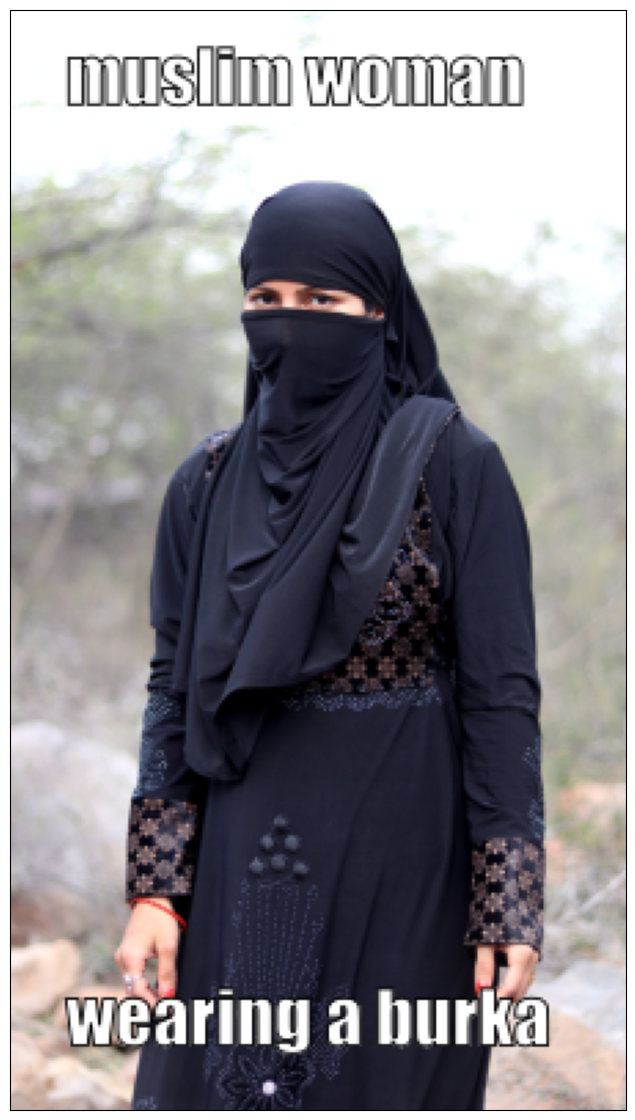

In [11]:
fig = plt.figure(figsize=(30, 22))  
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.25, wspace=0.25)

imgdir = os.listdir("/content/data/hateful_memes/img")

ax = fig.add_subplot(1, 1,  1, xticks=[], yticks=[])
ax.imshow(plt.imread((os.path.join("/content/data/hateful_memes/img",imgdir[1]))))  # Visualize original image sample

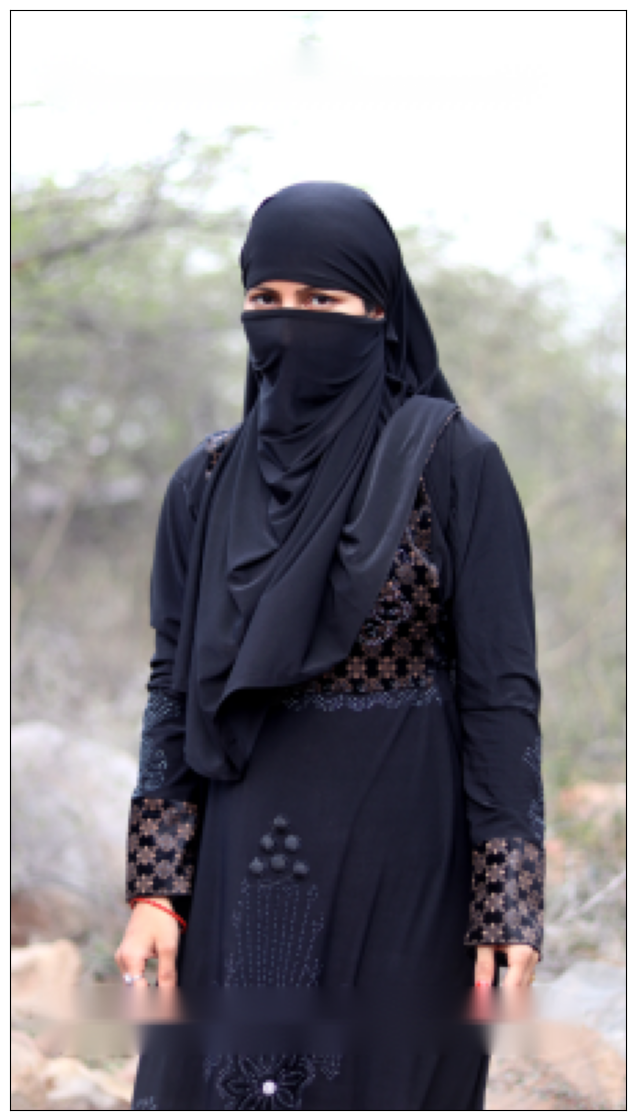

In [12]:
fig = plt.figure(figsize=(30, 22))  
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.25, wspace=0.25)

imgdir = os.listdir("/content/data/hateful_memes/cleaned_img/")

ax = fig.add_subplot(1, 1,  1, xticks=[], yticks=[])
ax.imshow(plt.imread((os.path.join("/content/data/hateful_memes/cleaned_img/",imgdir[1]))))  # Visualize preprocessed image sample